**Важно:** чтобы tensorflow > 2.4.x был совместим с CUDA, нужно собрать докер-образ c новым драйвером. Как это сделать, описано в [документации](https://cloud.yandex.ru/docs/datasphere/operations/user-images) и в ноутбуке [Настройка рабочей среды в DataSphere](environment_ru.ipynb#section-id0).

In [256]:
#Импортируем нужные библиотеки
import tensorflow as tf
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
#  X, y = make_classification(n_samples=1000, n_features=4,
# ...                            n_informative=2, n_redundant=0,
# ...                            random_state=0, shuffle=False)

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



In [195]:
%pip install seaborn
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [258]:
df = pd.read_csv('all_reasons_wo_dupl_with_nakl2.csv') 
odf = df
df.columns



Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'id', 'reason',
       'is_closed', 'close_dt', 'created_at', 'full_address',
       'expected_answer_dt', 'is_deleted', 'updated_at', 'status',
       'petition_id', 'petition_body', 'latitude', 'longitude', 'district',
       'district_id', 'building_id', 'building_prefix_id', 'building_house',
       'building_corpus', 'building_liter', 'is_public', 'category_name',
       'duplicate', 'covered_by', 'covered', 'reason_body', 'street',
       'match_address', 'match_id', 'match_address_ratio'],
      dtype='object')

In [259]:
ord_enc = OrdinalEncoder()
df["reason"] = ord_enc.fit_transform(df[["reason"]])
df['reason_body'] = ord_enc.fit_transform(df[["reason_body"]])
df["category_name"] = ord_enc.fit_transform(df[['category_name']])

for time in ['created_at', 'updated_at']:
    df[time + 'Year'] = df[time].apply(lambda timedel: timedel[:4])

    df[time + 'Month'] = df[time].apply(lambda timedel: timedel[5:7])

    df[time + 'Day'] = df[time].apply(lambda timedel: timedel[8:10])

    df[time + 'Hour'] = df[time].apply(lambda timedel: timedel[11:13])

    df[time + 'Minute'] = df[time].apply(lambda timedel: timedel[14:16])
  

In [260]:
X = df.drop(['duplicate', 'street', 'Unnamed: 0', 'full_address', 'petition_body', 'district', 'building_liter', 'close_dt', 'created_at', 'updated_at', 'expected_answer_dt', 'building_house', 'building_corpus'], axis = 1)
y = df['duplicate']
X.fillna(0, inplace=True)
    

In [261]:
X.columns

Index(['Unnamed: 0.1', 'Unnamed: 0.1.1', 'id', 'reason', 'is_closed',
       'is_deleted', 'status', 'petition_id', 'latitude', 'longitude',
       'district_id', 'building_id', 'building_prefix_id', 'is_public',
       'category_name', 'covered_by', 'covered', 'reason_body',
       'match_address', 'match_id', 'match_address_ratio', 'created_atYear',
       'created_atMonth', 'created_atDay', 'created_atHour',
       'created_atMinute', 'updated_atYear', 'updated_atMonth',
       'updated_atDay', 'updated_atHour', 'updated_atMinute'],
      dtype='object')

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2020, stratify=y)
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
print(rfc.score(X_train_scaled, y_train))

1.0


In [263]:
model = rfc
model.feature_importances_

array([0.05250781, 0.05699674, 0.06508242, 0.06916191, 0.0321552 ,
       0.        , 0.06687067, 0.07309232, 0.06979857, 0.04647934,
       0.01396007, 0.04973987, 0.05296919, 0.03951266, 0.08803774,
       0.0005182 , 0.00028617, 0.04413227, 0.00762151, 0.02628953,
       0.00690481, 0.        , 0.01639617, 0.01564183, 0.02153844,
       0.0220007 , 0.        , 0.00244957, 0.01535241, 0.02401281,
       0.0204911 ])

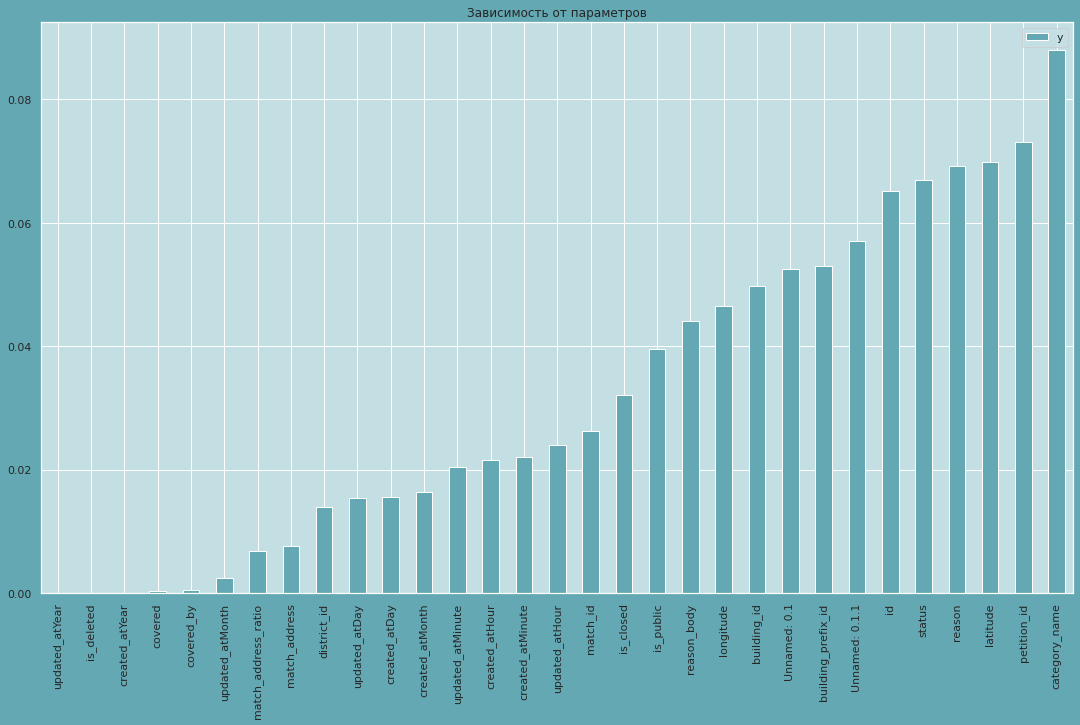

In [276]:

# (pd.Series(model.feature_importances_, index=X.columns)
#    .nlargest(len(X.columns))
#    .plot(kind='barh'))  

bars = {
    'x': X.columns,
    'y': model.feature_importances_
}

sns.set_theme(style="ticks")
sns.set(rc={'axes.facecolor':'#C4DFE3', 'figure.facecolor':'#64a8b3'})

# plt.savefig('G:\innozhk\static\moscow.png')
#bar = sns.barplot(x = 'x', y= 'y', data=bars, color='#64a8b3')
dfbars = pd.DataFrame.from_dict(bars)
dfbars = dfbars.sort_values(by=['y'])
bar = dfbars.set_index('x').plot(kind='bar', stacked=True, color=['#64a8b3', '#C4DFE3'])
#bar.set(xticklabels=[])
bar.set(title='Зависимость от параметров')
bar.set(ylabel=None, xlabel=None)
# plt.savefig('G:\innozhk\static\districts.png')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('districts.png')


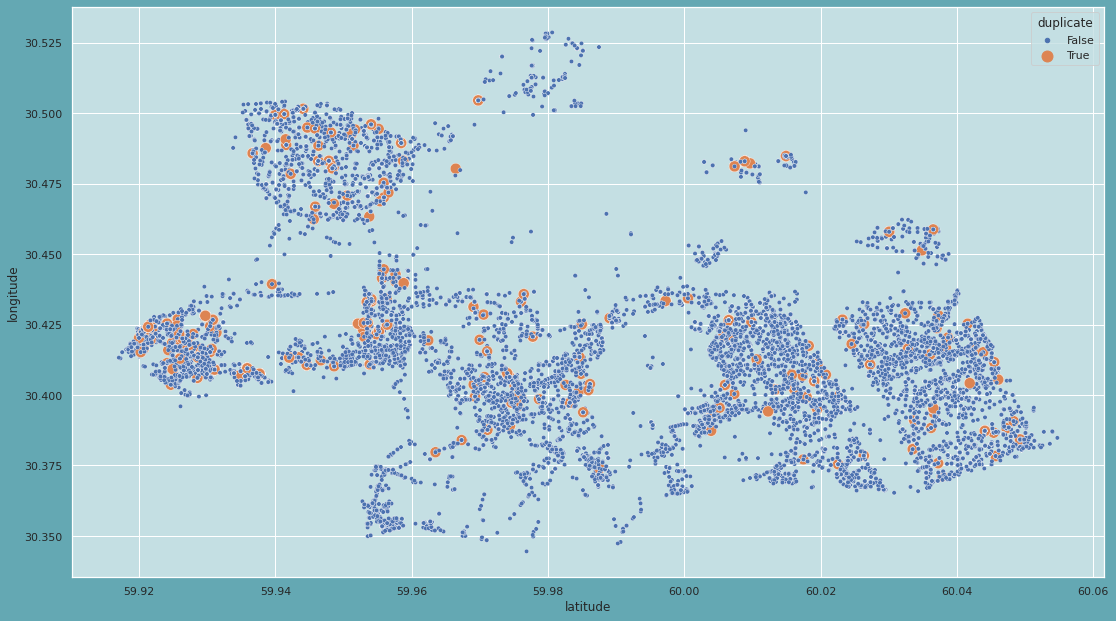

In [277]:
sns.scatterplot(data = df, x = "latitude", y = "longitude", hue='duplicate', hue_order=[False, True],size = 'duplicate',  sizes = {False : 20, True : 120})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('duplicate.png')


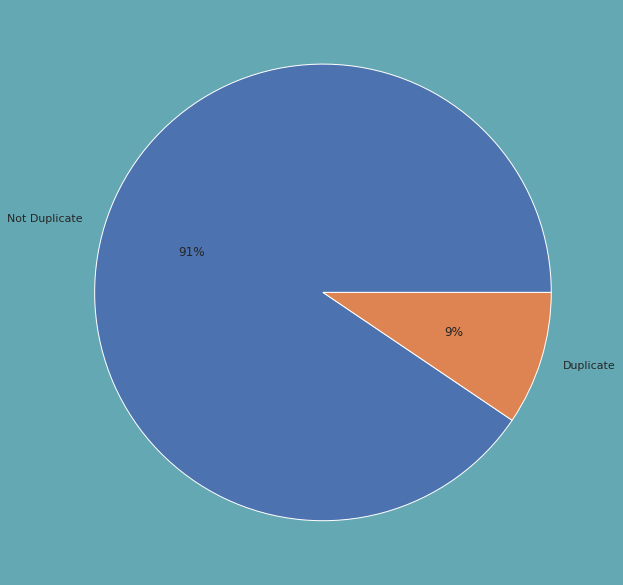

In [278]:


pdata = (df.duplicate.value_counts())
data = [df['duplicate'], 25, 25, 30, 5]
labels = ['Not Duplicate', 'Duplicate']

#define Seaborn color palette to use
# colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(pdata, labels = labels, autopct='%.0f%%')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('dupperc.png')


In [248]:
#!c1.4


In [253]:
# 59.95837
# odf.сфе
# odf.loc[odf.latitude == float(59.95837)]
#odf[odf.id == 4730521 or  odf.bar == 5531]
# odf[odf.duplicate & odf.building_prefix_id == float(5531)]
odf[odf.duplicate].to_csv('dubles.csv')

In [250]:
odf.created_at.sort_values()

9753    2022-08-25 17:30:27
9752    2022-08-25 17:34:15
9751    2022-08-25 17:42:34
9750    2022-08-25 17:59:12
9748    2022-08-25 18:14:01
               ...         
4       2022-12-02 20:30:08
14      2022-12-02 20:30:08
1       2022-12-02 20:30:08
9       2022-12-02 20:30:08
0       2022-12-02 20:30:08
Name: created_at, Length: 17093, dtype: object

In [269]:
mdf = 0
ddf = 0
for ind, row in odf.iterrows():
    d = str(row['created_at'])
    if d[5:7] == '09':
        mdf += 1
        
        if d[8:10] == '29':
            ddf += 1
        
print (mdf, ddf)
    

2816 85


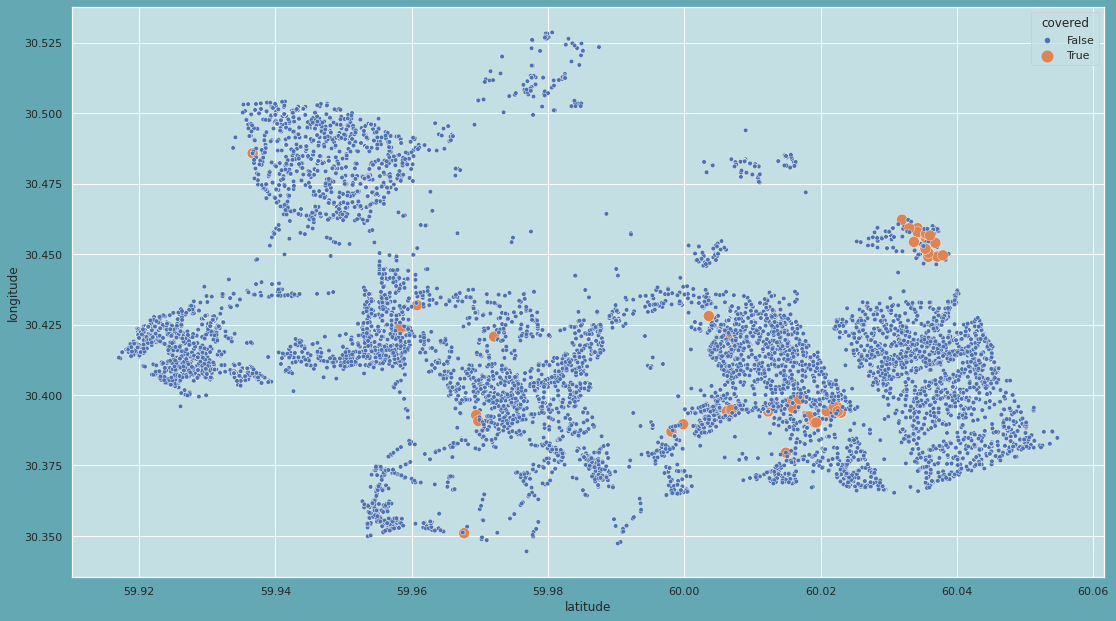

In [279]:
sns.scatterplot(data = odf, x = "latitude", y = "longitude", hue='covered', size = 'covered', sizes = {False : 20, True : 120})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('covered.png')


In [281]:
odf['match_adress'].value_counts()

KeyError: 'match_adress'